In [129]:
import os
import gc
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    path = '../../../datasets/garanti-bbva-data-camp/'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [130]:
train_df = pd.read_csv(os.path.join(config.path, 'train_users.csv'))
test_df = pd.read_csv(os.path.join(config.path, 'test_users.csv'))
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (53019, 4)
test_df shape: (13255, 3)


In [131]:
df = train_df.append(test_df).reset_index(drop = True)

df.head()

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [132]:
#df.loc[df['location'].astype(str).str.contains('Afyon')]

In [133]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

In [134]:
df = fix_location(df)

skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
edu_df = load_education(config.education_path, 12)
#exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
#df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 318624


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


(66274, 74)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_SQL,skill_C#,skill_Software Development,...,degree_Bachelor's degree,degree_Master's degree,degree_Bachelor of Science,degree_High School,degree_Master of Science,degree_Associate's degree,degree_Bachelor of Engineering,degree_Doctor of Philosophy,degree_Master of Business Administration,degree_Mühendislik Fakültesi Mezunu
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4880,Online Media,TURKEY,0.0,1,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
target = 'moved_after_2019'
cat_features = ['industry', 'location']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 73)
test_set: (13255, 73)


In [136]:
params = {'subsample': 0.8,
          'bootstrap_type':'Bernoulli',
          'depth': 9,
          'one_hot_max_size': 150}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

kf = KFold(n_splits=config.n_folds)


In [137]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6235797	test: 0.6193278	best: 0.6193278 (0)	total: 26ms	remaining: 2m 9s
200:	learn: 0.7217645	test: 0.6744370	best: 0.6745502 (186)	total: 2.8s	remaining: 1m 6s
400:	learn: 0.7660812	test: 0.6920901	best: 0.6923164 (399)	total: 5.4s	remaining: 1m 1s
600:	learn: 0.7904803	test: 0.7000113	best: 0.7012561 (583)	total: 8.03s	remaining: 58.8s
800:	learn: 0.8109864	test: 0.7051035	best: 0.7069141 (766)	total: 10.6s	remaining: 55.7s
1000:	learn: 0.8272373	test: 0.7069141	best: 0.7083852 (867)	total: 13.2s	remaining: 52.6s
1200:	learn: 0.8408628	test: 0.7146090	best: 0.7146090 (1199)	total: 15.7s	remaining: 49.6s
1400:	learn: 0.8535150	test: 0.7165328	best: 0.7176644 (1375)	total: 18.3s	remaining: 46.9s
1600:	learn: 0.8659861	test: 0.7199276	best: 0.7208329 (1584)	total: 20.9s	remaining: 44.4s
1800:	learn: 0.8761713	test: 0.7253593	best: 0.7256988 (1794)	total: 23.5s	rema

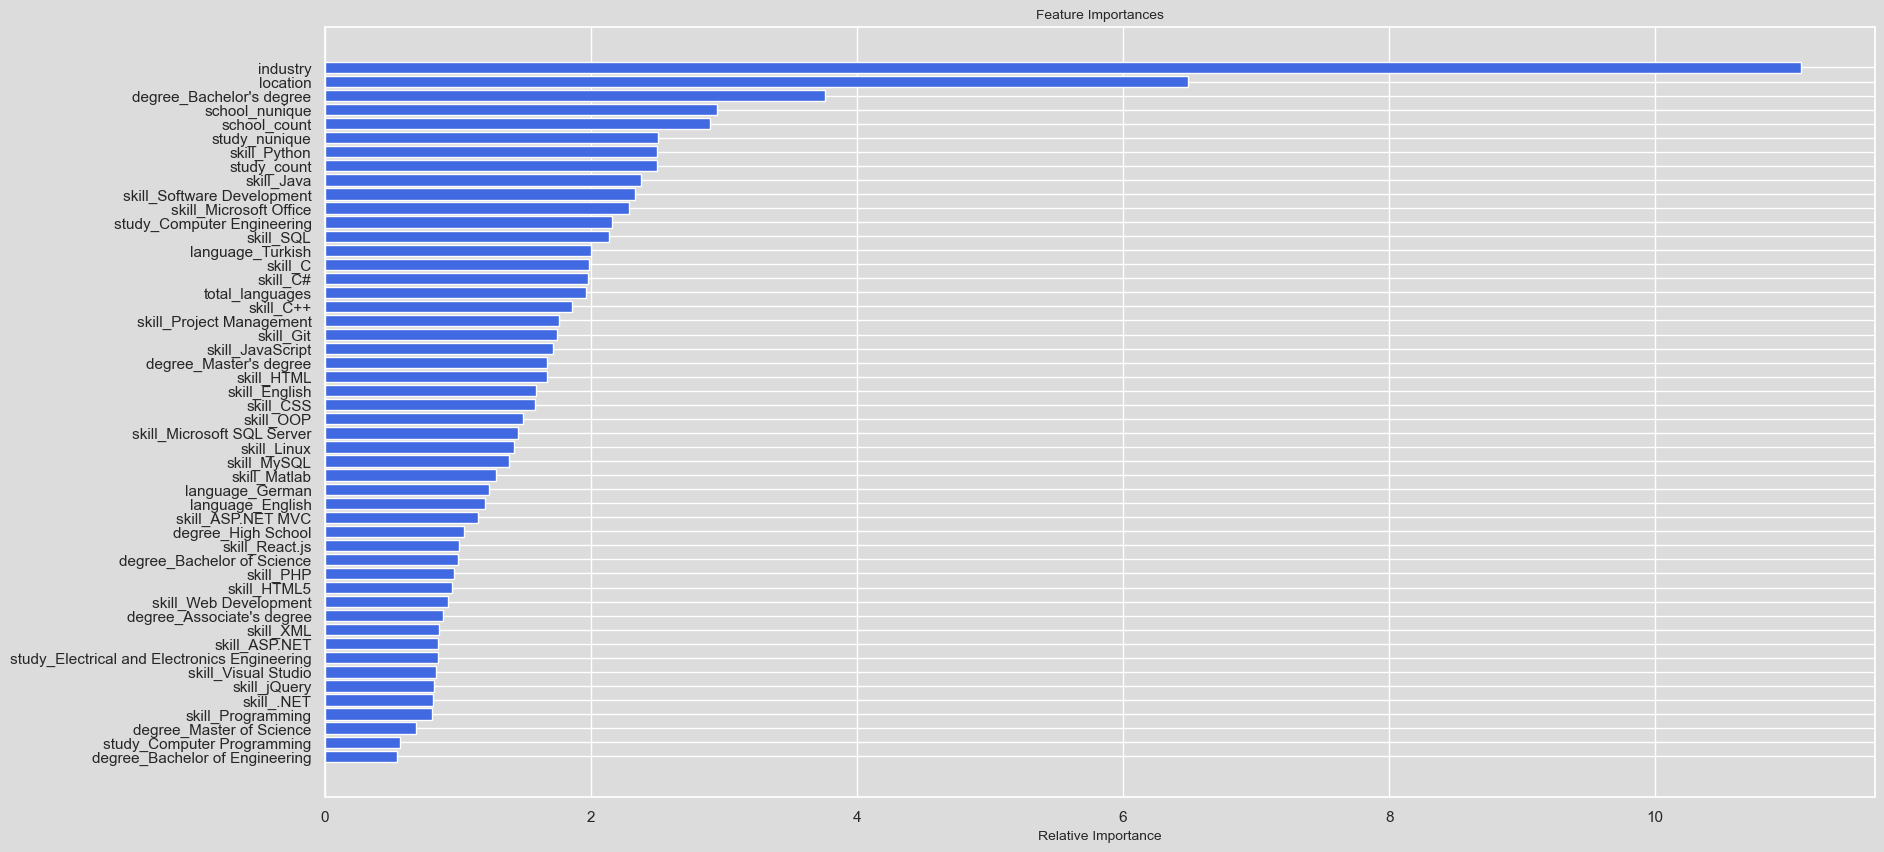

fold accuracy: 0.7414280864546792
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6230365	test: 0.6232884	best: 0.6232884 (0)	total: 14.1ms	remaining: 1m 10s
200:	learn: 0.7281246	test: 0.6738712	best: 0.6738712 (200)	total: 2.62s	remaining: 1m 2s
400:	learn: 0.7652211	test: 0.6925427	best: 0.6925427 (399)	total: 5.17s	remaining: 59.3s
600:	learn: 0.7924720	test: 0.7028403	best: 0.7028403 (600)	total: 7.71s	remaining: 56.4s
800:	learn: 0.8112127	test: 0.7058957	best: 0.7060088 (781)	total: 10.2s	remaining: 53.7s
1000:	learn: 0.8270563	test: 0.7097431	best: 0.7099694 (987)	total: 12.8s	remaining: 51.2s
1200:	learn: 0.8421755	test: 0.7142695	best: 0.7142695 (1200)	total: 15.4s	remaining: 48.7s
1400:	learn: 0.8550994	test: 0.7190223	best: 0.7192486 (1359)	total: 18s	remaining: 46.2s
1600:	learn: 0.8643339	test: 0.7207197	best: 0.7215118 (1584)	total: 20.6s	remaining: 43.7s
1800:	learn: 0.8761939	test: 0.7237750	bes

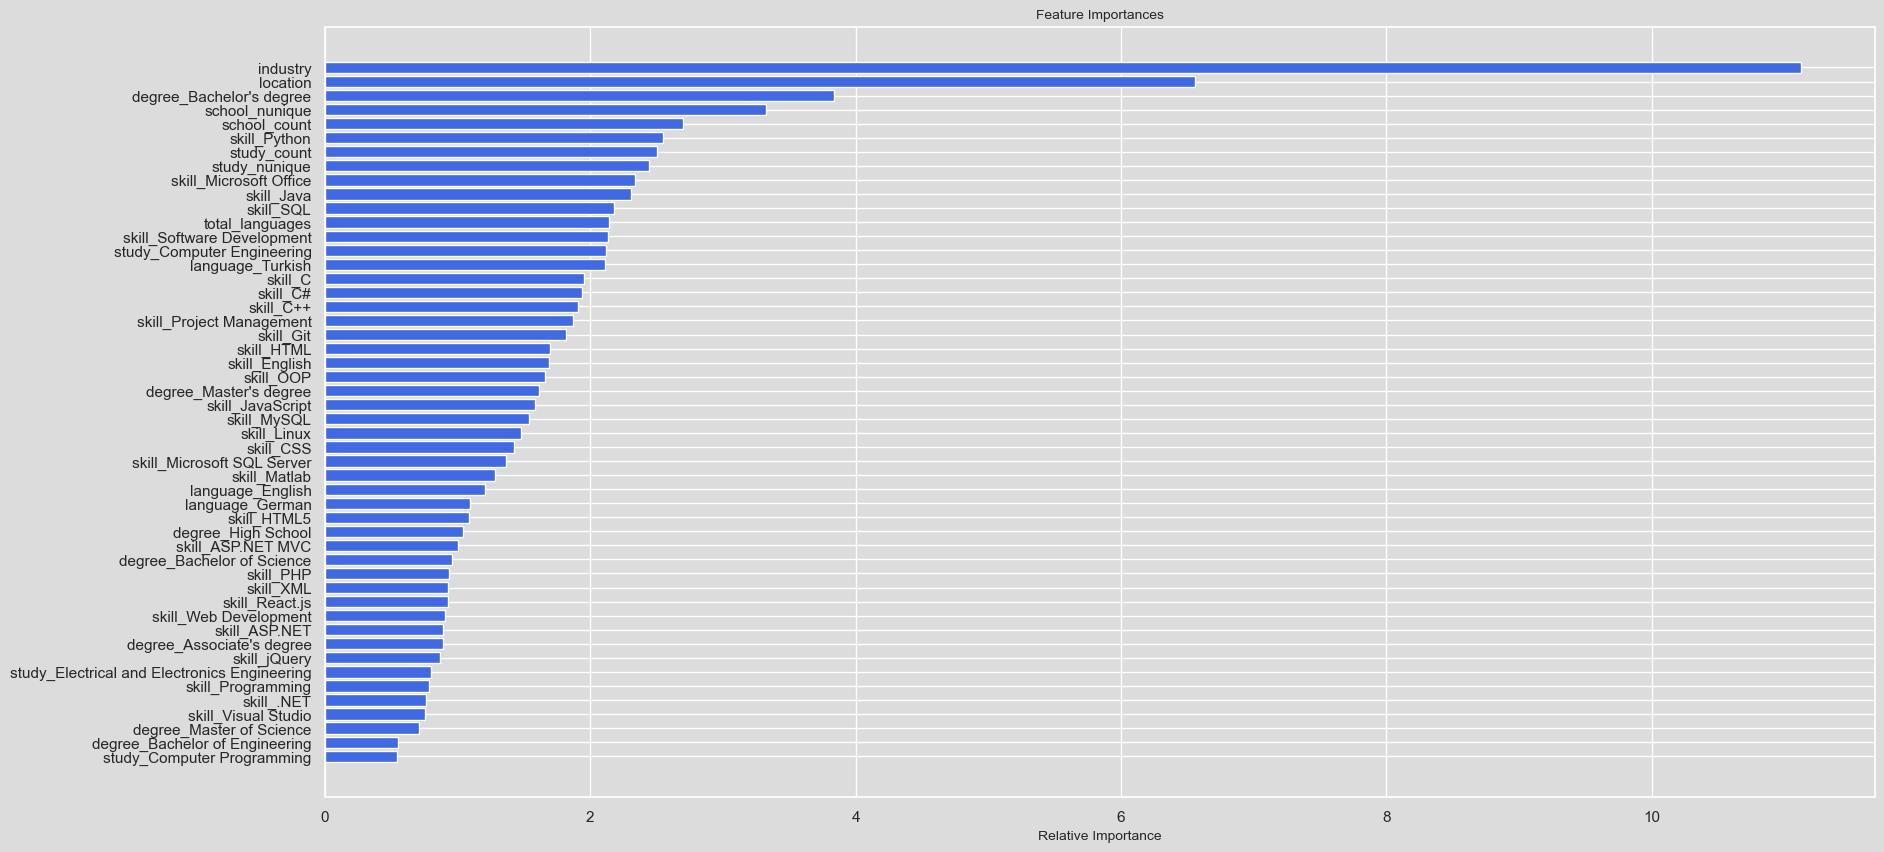

fold accuracy: 0.7378069480592961
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6263637	test: 0.6218174	best: 0.6218174 (0)	total: 15ms	remaining: 1m 14s
200:	learn: 0.7257480	test: 0.6737581	best: 0.6737581 (197)	total: 2.79s	remaining: 1m 6s
400:	learn: 0.7618487	test: 0.6865452	best: 0.6877900 (390)	total: 5.4s	remaining: 1m 1s
600:	learn: 0.7907745	test: 0.6968428	best: 0.6984271 (580)	total: 8s	remaining: 58.5s
800:	learn: 0.8102621	test: 0.7049904	best: 0.7049904 (796)	total: 10.6s	remaining: 55.6s
1000:	learn: 0.8281427	test: 0.7112142	best: 0.7112142 (1000)	total: 13.2s	remaining: 52.7s
1200:	learn: 0.8423792	test: 0.7155143	best: 0.7156275 (1168)	total: 15.7s	remaining: 49.8s
1400:	learn: 0.8544656	test: 0.7200407	best: 0.7209460 (1390)	total: 18.3s	remaining: 47s
1600:	learn: 0.8648997	test: 0.7227566	best: 0.7242277 (1541)	total: 20.9s	remaining: 44.4s
1800:	learn: 0.8745190	test: 0.7242277	best: 0.

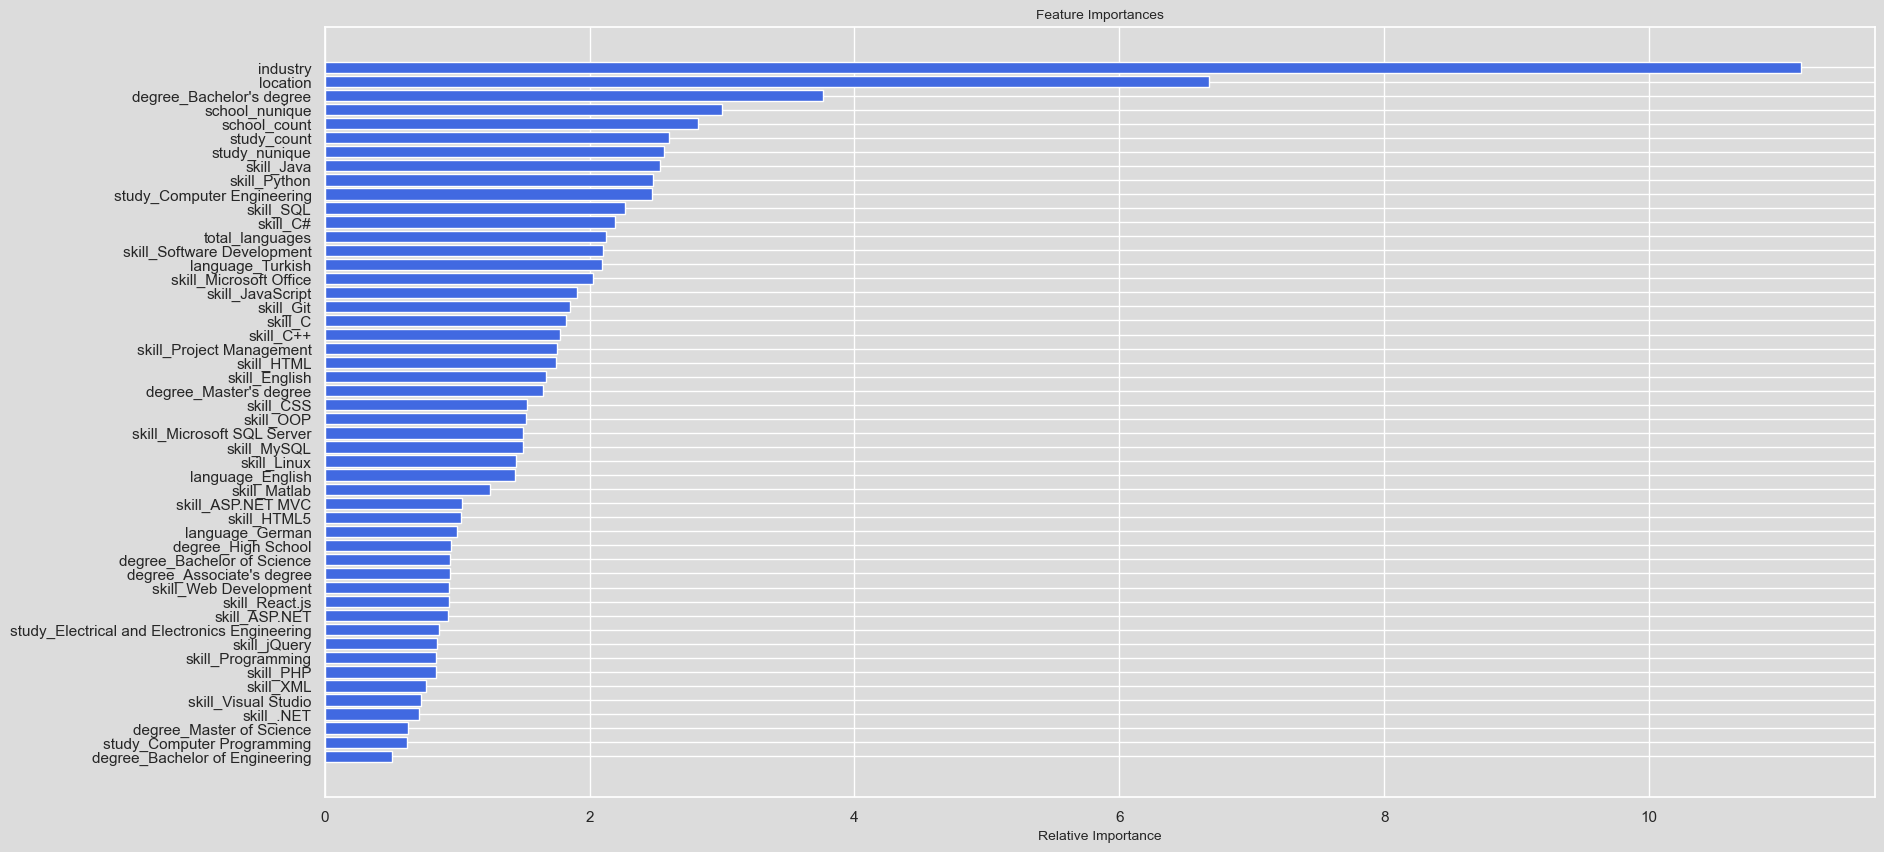

fold accuracy: 0.7458413488740523
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6159835	test: 0.6174740	best: 0.6174740 (0)	total: 9.69ms	remaining: 48.4s
200:	learn: 0.7253695	test: 0.6723631	best: 0.6728158 (198)	total: 2.68s	remaining: 1m 3s
400:	learn: 0.7677614	test: 0.6867361	best: 0.6875283 (390)	total: 5.27s	remaining: 1m
600:	learn: 0.7942874	test: 0.6971480	best: 0.6976007 (582)	total: 7.83s	remaining: 57.3s
800:	learn: 0.8147930	test: 0.7040516	best: 0.7043911 (796)	total: 10.4s	remaining: 54.4s
1000:	learn: 0.8297535	test: 0.7074468	best: 0.7076732 (947)	total: 12.9s	remaining: 51.5s
1200:	learn: 0.8447819	test: 0.7114079	best: 0.7122001 (1198)	total: 15.5s	remaining: 48.9s
1400:	learn: 0.8559174	test: 0.7152558	best: 0.7163875 (1365)	total: 18.1s	remaining: 46.5s
1600:	learn: 0.8652649	test: 0.7159348	best: 0.7163875 (1365)	total: 20.7s	remaining: 43.9s
1800:	learn: 0.8748387	test: 0.7208013	best:

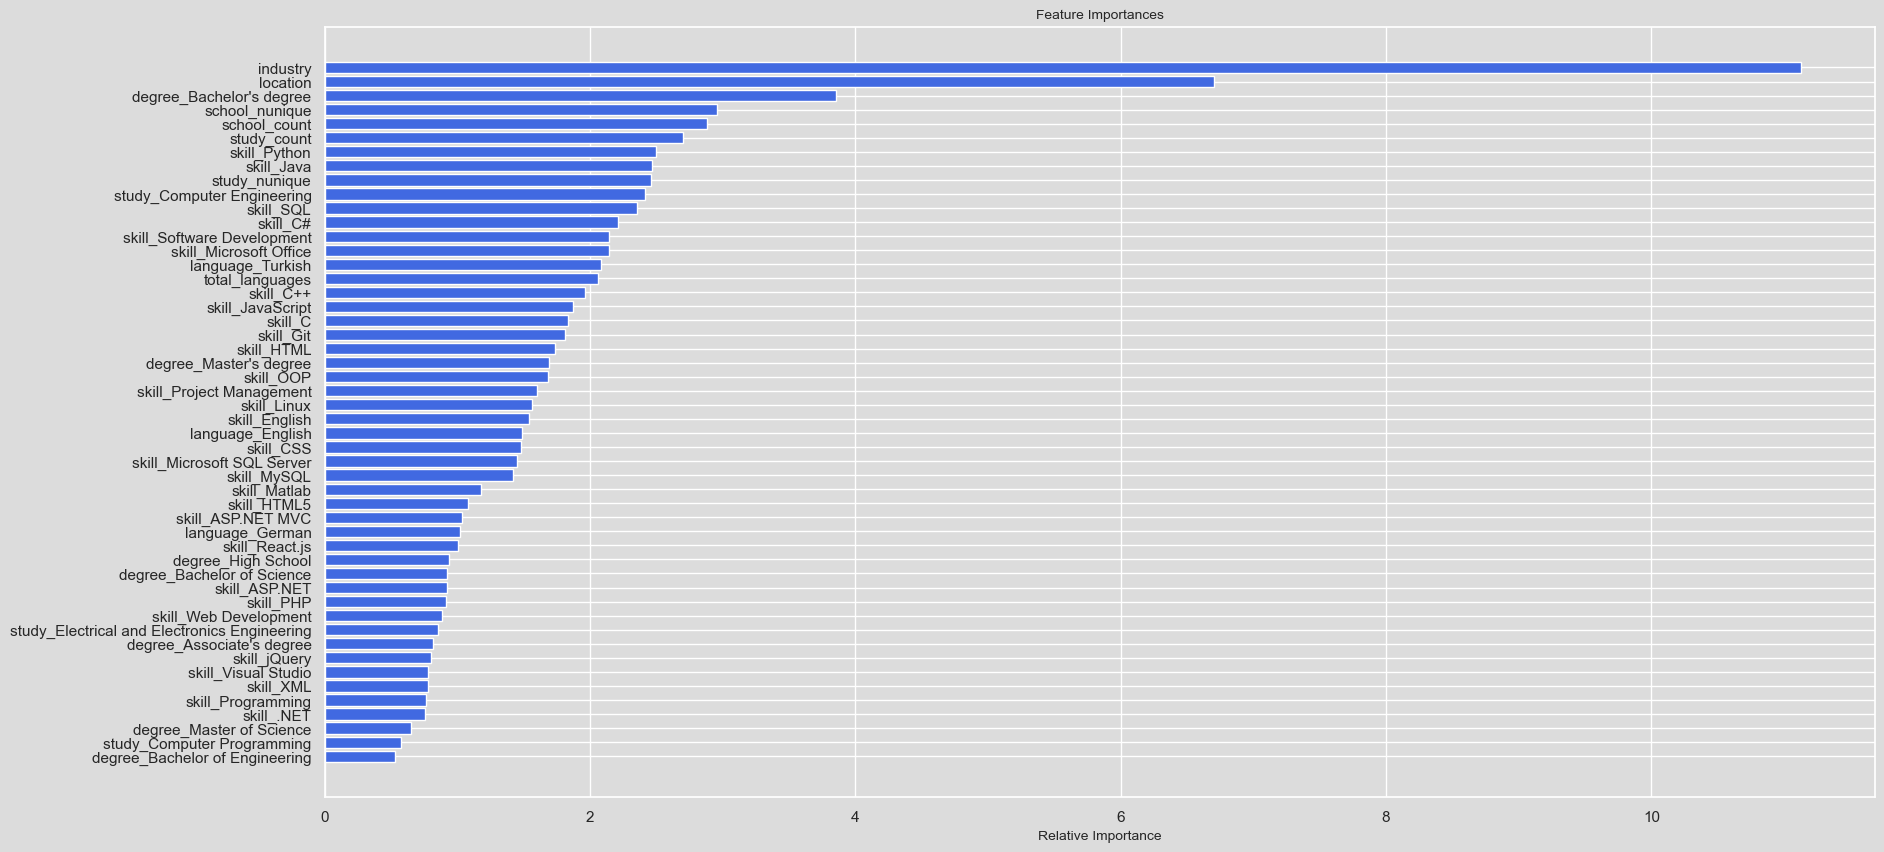

fold accuracy: 0.7377772747849706
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6192427	test: 0.6195111	best: 0.6195111 (0)	total: 20ms	remaining: 1m 40s
200:	learn: 0.7261843	test: 0.6722499	best: 0.6722499 (200)	total: 3.25s	remaining: 1m 17s
400:	learn: 0.7649322	test: 0.6929606	best: 0.6929606 (400)	total: 6.42s	remaining: 1m 13s
600:	learn: 0.7927257	test: 0.7033726	best: 0.7040516 (557)	total: 9.67s	remaining: 1m 10s
800:	learn: 0.8129597	test: 0.7081258	best: 0.7095971 (752)	total: 12.9s	remaining: 1m 7s
1000:	learn: 0.8271507	test: 0.7157085	best: 0.7161612 (990)	total: 16.1s	remaining: 1m 4s
1200:	learn: 0.8402779	test: 0.7178588	best: 0.7185378 (1109)	total: 19.2s	remaining: 1m
1400:	learn: 0.8527488	test: 0.7221593	best: 0.7223857 (1387)	total: 22.4s	remaining: 57.5s
1600:	learn: 0.8634090	test: 0.7264599	best: 0.7274785 (1581)	total: 25.5s	remaining: 54.2s
1800:	learn: 0.8740013	test: 0.7275917	bes

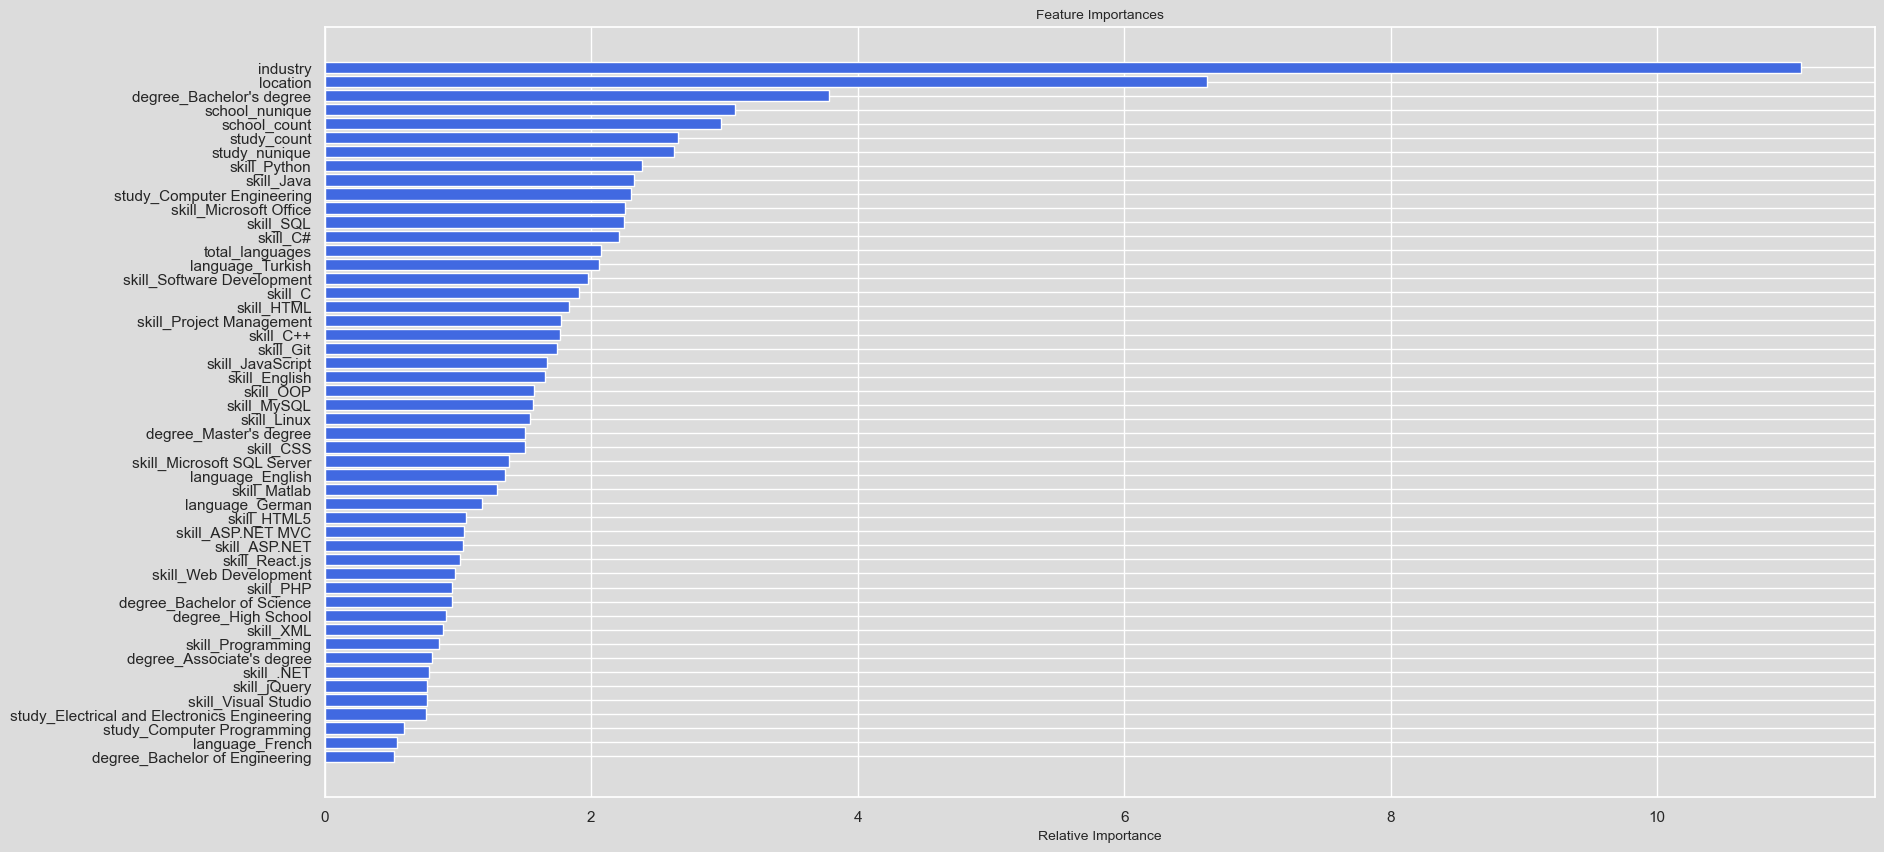

fold accuracy: 0.7461521050248981
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6172510	test: 0.6111363	best: 0.6111363 (0)	total: 9.61ms	remaining: 48s
200:	learn: 0.7259127	test: 0.6679493	best: 0.6679493 (200)	total: 2.88s	remaining: 1m 8s
400:	learn: 0.7633253	test: 0.6764373	best: 0.6783612 (342)	total: 5.52s	remaining: 1m 3s
600:	learn: 0.7897155	test: 0.6920552	best: 0.6920552 (600)	total: 8.09s	remaining: 59.2s
800:	learn: 0.8110133	test: 0.6989588	best: 0.6996378 (792)	total: 10.6s	remaining: 55.7s
1000:	learn: 0.8291651	test: 0.7086917	best: 0.7086917 (1000)	total: 13.2s	remaining: 52.9s
1200:	learn: 0.8426318	test: 0.7110684	best: 0.7119737 (1191)	total: 16.1s	remaining: 51.1s
1400:	learn: 0.8564833	test: 0.7159348	best: 0.7163875 (1373)	total: 19s	remaining: 48.9s
1600:	learn: 0.8666682	test: 0.7183115	best: 0.7189905 (1598)	total: 22.1s	remaining: 46.9s
1800:	learn: 0.8752009	test: 0.7200091	best:

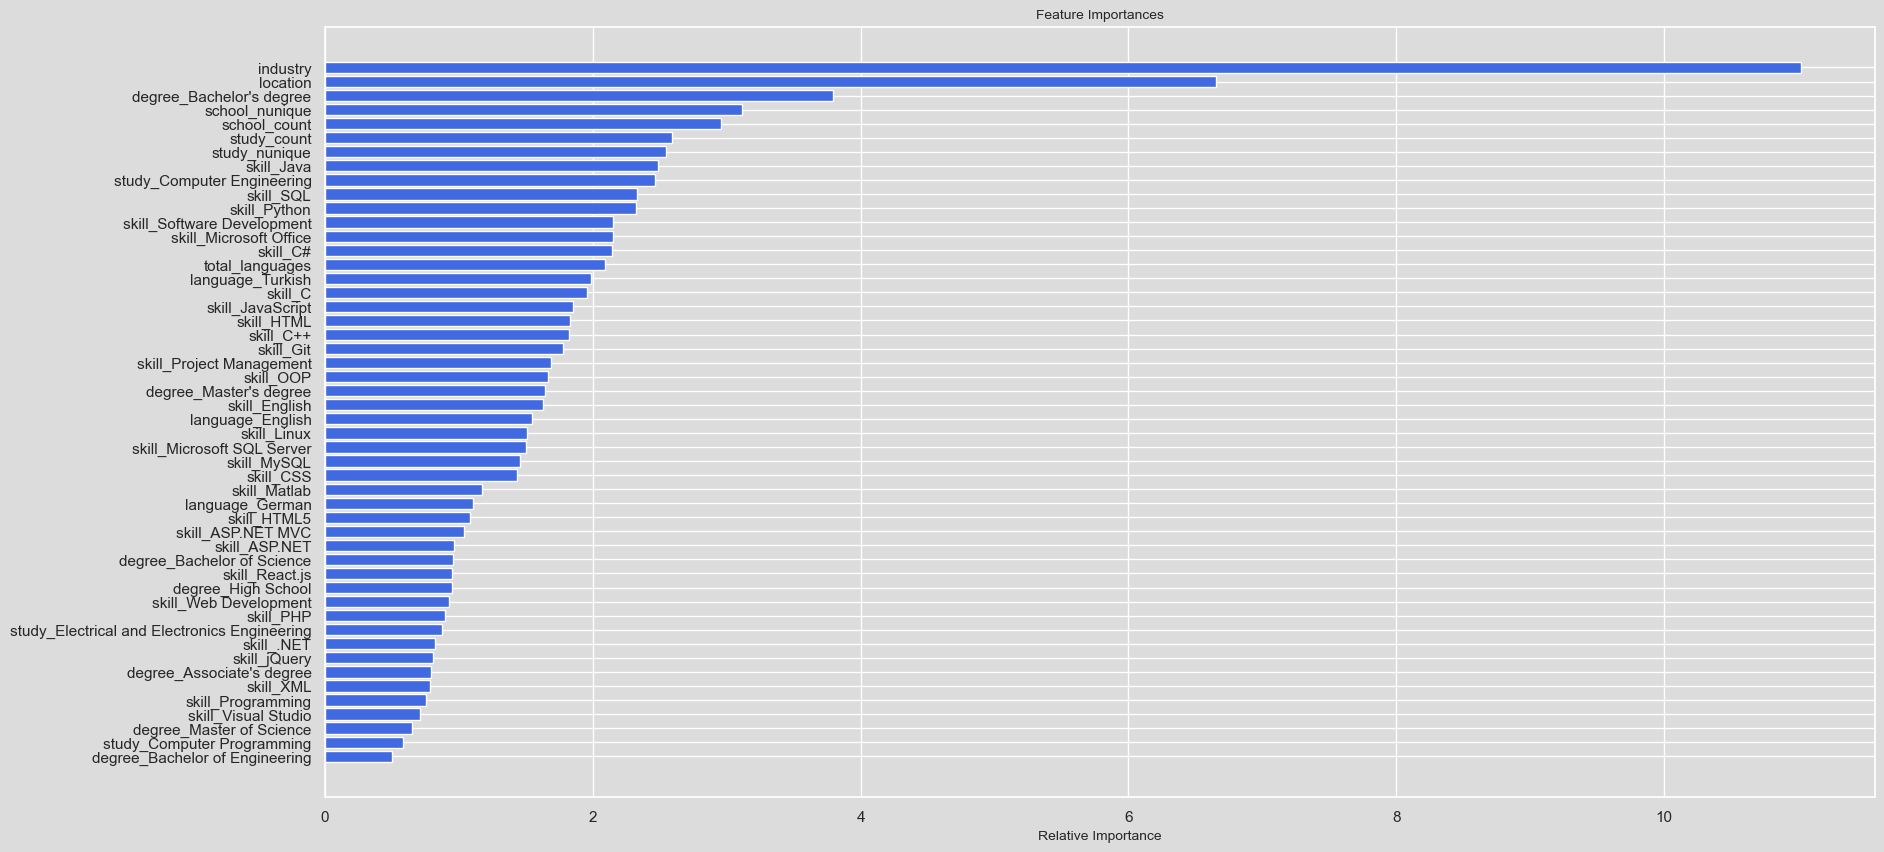

fold accuracy: 0.7399275690357627
accuracy: 0.7414889002055867


In [138]:
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')

In [139]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,0
2,2110,0
3,55082,0
4,37165,0


In [140]:
sub.to_csv(f'../submissions/submission_{round(val_score, 6)}.csv', index = False)